In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline


pd.set_option('display.max_columns', None)
from sklearn.preprocessing import OneHotEncoder,StandardScaler,PowerTransformer,LabelEncoder

In [2]:
orig_data = pd.read_csv('churn_data.csv')
orig_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
data = orig_data.copy()

### Adding the start date column

Assuming the data is from June 1st, 2021

    tenure of 72 => 2021-06-01
    tenure of 0  => 2021-08-12 

In [4]:
# checking if there are duplicates in customer IDs
len(data), len(data.customerID.unique())

(7043, 7043)

In [5]:
min_tenure = min(data.tenure)
max_tenure = max(data.tenure)

print(min_tenure, max_tenure)

0 72


In [6]:
tenure_list = list(range(min_tenure,max_tenure+1))

In [7]:
date_df = pd.DataFrame(tenure_list[::-1], columns=['tenure'])

date_df['start_date'] = pd.to_datetime(tenure_list, unit='D', origin=pd.Timestamp('2021-06-01'))

data = pd.merge(data, date_df, on=['tenure'],how='left')

In [8]:
data_backup = data.copy()

-----------------------------------------------------------

### EDA Summary

---------------------

# EDA

In [9]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,start_date
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,2021-08-11
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No,2021-07-09
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,2021-08-10
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,2021-06-28
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,2021-08-10


### 1. missing values check

In [10]:
data.isnull().sum().sort_values(ascending=False)

start_date          0
Churn               0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
customerID          0
dtype: int64

In [11]:
data['TotalCharges']= data['TotalCharges'].apply(lambda x: x if x!= ' ' else np.nan).astype(float)

### 2. Target variable

In [12]:
y = data['Churn']
print(f'Percentage of Churn:  {round(y.value_counts(normalize=True)[1]*100,2)} %  --> ({y.value_counts()[1]} customers)\nNo churn: {round(y.value_counts(normalize=True)[0]*100,2)}  %  --> ({y.value_counts()[0]} customers)')

# -> we have imbalanced data

Percentage of Churn:  26.54 %  --> (1869 customers)
No churn: 73.46  %  --> (5174 customers)


In [13]:
le = LabelEncoder()
data['Churn']=le.fit_transform(data['Churn'])

### 3. Numerical Features

In [14]:
numerical_features_list= data.select_dtypes('number').columns



In [15]:
data[numerical_features_list].describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn
count,7043.000000,7043.000000,7043.000000,7032.000000,7043.000000
mean,0.162147,32.371149,64.761692,2283.300441,0.265370
std,0.368612,24.559481,30.090047,2266.771362,0.441561
min,0.000000,0.000000,18.250000,18.800000,0.000000
25%,0.000000,9.000000,35.500000,401.450000,0.000000
50%,0.000000,29.000000,70.350000,1397.475000,0.000000
75%,0.000000,55.000000,89.850000,3794.737500,1.000000
max,1.000000,72.000000,118.750000,8684.800000,1.000000


In [16]:
data[data.TotalCharges.isna()==True]
data[data.tenure==0]
# Newly added customers have total charges-> None 

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,start_date
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,0,2021-08-12
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,0,2021-08-12
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,0,2021-08-12
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,0,2021-08-12
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,0,2021-08-12
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,0,2021-08-12
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,0,2021-08-12
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,0,2021-08-12
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,0,2021-08-12
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,0,2021-08-12


In [17]:
data[numerical_features_list].corr()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn
SeniorCitizen,1.000000,0.016567,0.220173,0.102411,0.150889
tenure,0.016567,1.000000,0.247900,0.825880,-0.352229
MonthlyCharges,0.220173,0.247900,1.000000,0.651065,0.193356
TotalCharges,0.102411,0.825880,0.651065,1.000000,-0.199484
Churn,0.150889,-0.352229,0.193356,-0.199484,1.000000


#### Numerical Features summary from correlation matrix:   
1. Weak level correlation between the numerical features and the target variable
2. Being senior citizen and increasing monthly charges have a positive correlation with the churn
3. Senior citizen more likely churn than younger customers
4. Strong correlation between tenure and total charges
5. Customer with higher monthly charges also more likely churn than lesser monthly charges customers
6. Total charges has negative correlation with the churn but might not be substantial

### 4. Categorical features

In [18]:
data = data.drop(['customerID'],axis=1).copy()

In [19]:
# Checking cardinality
categorical_features_list = list(data.select_dtypes('object').columns)
data[categorical_features_list].nunique()

gender              2
Partner             2
Dependents          2
PhoneService        2
MultipleLines       3
InternetService     3
OnlineSecurity      3
OnlineBackup        3
DeviceProtection    3
TechSupport         3
StreamingTV         3
StreamingMovies     3
Contract            3
PaperlessBilling    2
PaymentMethod       4
dtype: int64

In [20]:
data = data.replace('No internet service','No')
data.MultipleLines = data.MultipleLines.replace('No phone service','No')

In [21]:
for feature in categorical_features_list:
        print(f'{feature}: {data[feature].unique()}')

gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes']
OnlineBackup: ['Yes' 'No']
DeviceProtection: ['No' 'Yes']
TechSupport: ['No' 'Yes']
StreamingTV: ['No' 'Yes']
StreamingMovies: ['No' 'Yes']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


#### a. Gender vs Churn

In [22]:
print (f'A female customer has a probability of {round(data[data["gender"]=="Female"]["Churn"].mean()*100,2)} % churn')
print (f'A male customer has a probability of {round(data[data["gender"]=="Male"]["Churn"].mean()*100,2)} % churn')

A female customer has a probability of 26.92 % churn
A male customer has a probability of 26.16 % churn


#### b. Having Partner Vs Churn

In [23]:
print (f'A customer with a partner has a probability of {round(data[data["Partner"]=="Yes"]["Churn"].mean()*100,2)} % churn')
print (f'A customer without any partner has a probability of {round(data[data["Partner"]=="No"]["Churn"].mean()*100,2)} % churn')

A customer with a partner has a probability of 19.66 % churn
A customer without any partner has a probability of 32.96 % churn


#### c. Having Dependents Vs Churn

In [24]:
print (f'A customer with dependents has a probability of {round(data[data["Dependents"]=="Yes"]["Churn"].mean()*100,2)} % churn')
print (f'A customer without any dependents has a probability of {round(data[data["Dependents"]=="No"]["Churn"].mean()*100,2)} % churn')

A customer with dependents has a probability of 15.45 % churn
A customer without any dependents has a probability of 31.28 % churn


#### d. Phone Service Vs Churn

In [25]:
print (f'A customer with a phone service has a probability of {round(data[data["PhoneService"]=="Yes"]["Churn"].mean()*100,2)} % churn')
print (f'A customer without any phone service has a probability of {round(data[data["PhoneService"]=="No"]["Churn"].mean()*100,2)} % churn')

A customer with a phone service has a probability of 26.71 % churn
A customer without any phone service has a probability of 24.93 % churn


#### e. Multiple Lines Vs Churn

In [26]:
print (f'A customer with a multiple lines has a probability of {round(data[data["MultipleLines"]=="Yes"]["Churn"].mean()*100,2)} % churn')
print (f'A customer without multiple lines has a probability of {round(data[data["MultipleLines"]=="No"]["Churn"].mean()*100,2)} % churn')

A customer with a multiple lines has a probability of 28.61 % churn
A customer without multiple lines has a probability of 25.02 % churn


#### f. Internet Service Vs Churn

In [27]:
print (f'A customer with a Fiber Optic internet service has a probability of {round(data[data["InternetService"]=="Fiber optic"]["Churn"].mean()*100,2)} % churn')
print (f'A customer with a DSL internet service has a probability of {round(data[data["InternetService"]=="DSL"]["Churn"].mean()*100,2)} % churn')
print (f'A customer without any internet service has a probability of {round(data[data["InternetService"]=="No"]["Churn"].mean()*100,2)} % churn')

A customer with a Fiber Optic internet service has a probability of 41.89 % churn
A customer with a DSL internet service has a probability of 18.96 % churn
A customer without any internet service has a probability of 7.4 % churn


#### g. Online Security Vs Churn

In [28]:
print (f'A customer with a online security has a probability of {round(data[data["OnlineSecurity"]=="Yes"]["Churn"].mean()*100,2)} % churn')
print (f'A customer without any online security has a probability of {round(data[data["OnlineSecurity"]=="No"]["Churn"].mean()*100,2)} % churn')

A customer with a online security has a probability of 14.61 % churn
A customer without any online security has a probability of 31.33 % churn


#### h. Online Backup Vs Churn

In [29]:
print (f'A customer with a online backup has a probability of {round(data[data["OnlineBackup"]=="Yes"]["Churn"].mean()*100,2)} % churn')
print (f'A customer without any online backup has a probability of {round(data[data["OnlineBackup"]=="No"]["Churn"].mean()*100,2)} % churn')

A customer with a online backup has a probability of 21.53 % churn
A customer without any online backup has a probability of 29.17 % churn


#### i. Tech Support and Churn

In [30]:
print (f'A customer with a Tech Support has a probability of {round(data[data["TechSupport"]=="Yes"]["Churn"].mean()*100,2)} % churn')
print (f'A customer without any Tech Support has a probability of {round(data[data["TechSupport"]=="No"]["Churn"].mean()*100,2)} % churn')

A customer with a Tech Support has a probability of 15.17 % churn
A customer without any Tech Support has a probability of 31.19 % churn


#### j. Contract Type Vs Churn

In [31]:
print (f'A customer with a Month to month contract has a probability of {round(data[data["Contract"]=="Month-to-month"]["Churn"].mean()*100,2)} % churn')
print (f'A customer with a Two year contract has a probability of {round(data[data["Contract"]=="Two year"]["Churn"].mean()*100,2)} % churn')
print (f'A customer with a One year contract has a probability of {round(data[data["Contract"]=="One year"]["Churn"].mean()*100,2)} % churn')


A customer with a Month to month contract has a probability of 42.71 % churn
A customer with a Two year contract has a probability of 2.83 % churn
A customer with a One year contract has a probability of 11.27 % churn


#### k. Paperless Billing Vs Churn

In [32]:
print (f'A customer with a Paperless billing  has a probability of {round(data[data["PaperlessBilling"]=="Yes"]["Churn"].mean()*100,2)} % churn')
print (f'A customer without a Paperless billing has a probability of {round(data[data["PaperlessBilling"]=="No"]["Churn"].mean()*100,2)} % churn')

A customer with a Paperless billing  has a probability of 33.57 % churn
A customer without a Paperless billing has a probability of 16.33 % churn


#### l. Payment Method Vs Churn

In [33]:
print (f'A customer with a Payment method as a Electornic Check has a probability of {round(data[data["PaymentMethod"]=="Electronic check"]["Churn"].mean()*100,2)} % churn')
print (f'A customer with a Payment method as a Mailed Check has a probability of {round(data[data["PaymentMethod"]=="Mailed check"]["Churn"].mean()*100,2)} % churn')
print (f'A customer with a Payment method as a Bank transfer (automatic) has a probability of {round(data[data["PaymentMethod"]=="Bank transfer (automatic)"]["Churn"].mean()*100,2)} % churn')
print (f'A customer with a Payment method as a Credit card (automatic) has a probability of {round(data[data["PaymentMethod"]=="Credit card (automatic)"]["Churn"].mean()*100,2)} % churn')

A customer with a Payment method as a Electornic Check has a probability of 45.29 % churn
A customer with a Payment method as a Mailed Check has a probability of 19.11 % churn
A customer with a Payment method as a Bank transfer (automatic) has a probability of 16.71 % churn
A customer with a Payment method as a Credit card (automatic) has a probability of 15.24 % churn


In [34]:
data.start_date = pd.to_datetime(data.start_date)

In [35]:
data['day'] = data.start_date.dt.day
data['month'] = data.start_date.dt.month
data['weekday'] = data.start_date.dt.weekday
data['week_of_year'] = data.start_date.dt.week
data['year'] = data.start_date.dt.year

data.head()

<ipython-input-35-1d32893c91df>:4: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,start_date,day,month,weekday,week_of_year,year
0,Female,0,Yes,No,1,No,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,2021-08-11,11,8,2,32,2021
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0,2021-07-09,9,7,4,27,2021
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,2021-08-10,10,8,1,32,2021
3,Male,0,No,No,45,No,No,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,2021-06-28,28,6,0,26,2021
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,2021-08-10,10,8,1,32,2021


In [36]:
data.year= data.year.astype(str)
categorical_features_list.append('year')

In [37]:
# # Day
# data['day_sin'] = np.sin(data.day*(2.*np.pi/30))
# data['day_cos'] = np.cos(data.day*(2.*np.pi/30))

# # Month
# data['month_sin'] = np.sin(data.month*(2.*np.pi/12))
# data['month_cos'] = np.cos(data.month*(2.*np.pi/12))

# # weekday
# data['weekday_sin'] = np.sin(data.weekday*(2.*np.pi/12))
# data['weekday_cos'] = np.cos(data.weekday*(2.*np.pi/12))

# data.head()

#### Categorical Features summary
1. No much difference between gender on the churn rate
2. A single customer is 1.7 times more likely churn than cutomer with a partner
3. A customer without any dependents is 2 times more likely churn than cutomer with a dependent
4. Customer with fiber optic internet with the company compare to customer without any internet service with the company 5.66 times more likely to churn and higher as compared to DSL as well
5. A customer with a Tech Support service with the company almost 2 times less likely to leave the company than a customer without any a Tech Support service with the company
6. A customer with a Month to month contract has the highest churn probability
7. Payment method of Electronic Check has the highest churn rate probability

In [38]:
data.Churn.value_counts()

0    5174
1    1869
Name: Churn, dtype: int64

### Data Cleaning

In [39]:
## Delete missing rows
data.isna().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
start_date           0
day                  0
month                0
weekday              0
week_of_year         0
year                 0
dtype: int64

In [40]:
data = data[~data.TotalCharges.isna()]

In [41]:
data.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn', 'start_date', 'day', 'month',
       'weekday', 'week_of_year', 'year'],
      dtype='object')

### Encoding

In [42]:
# Enconde Churn
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['Churn'] = le.fit_transform(data['Churn'])
data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,start_date,day,month,weekday,week_of_year,year
0,Female,0,Yes,No,1,No,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,2021-08-11,11,8,2,32,2021
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0,2021-07-09,9,7,4,27,2021
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,2021-08-10,10,8,1,32,2021
3,Male,0,No,No,45,No,No,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,2021-06-28,28,6,0,26,2021
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,2021-08-10,10,8,1,32,2021


In [43]:
def encode_categorical_columns(categorical_columns, df):
    for column in categorical_columns:
        tempdf = pd.get_dummies(df[column], prefix=column)
        df = pd.merge(
            left=df,
            right=tempdf,
            left_index=True,
            right_index=True,
        )
        df = df.drop(columns=column)
    return df

In [44]:
data = encode_categorical_columns(categorical_features_list, data)

In [45]:
data_backup = data.copy()

## Modeling

In [46]:
import h2o
from h2o.automl import *

In [47]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "16" 2021-03-16; Java(TM) SE Runtime Environment (build 16+36-2231); Java HotSpot(TM) 64-Bit Server VM (build 16+36-2231, mixed mode, sharing)
  Starting server from /Users/icluster/opt/anaconda3/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/rx/mmjvt9zd54gbn8dkpwjv5kh80000gn/T/tmp7eyxr0d7
  JVM stdout: /var/folders/rx/mmjvt9zd54gbn8dkpwjv5kh80000gn/T/tmp7eyxr0d7/h2o_icluster_started_from_python.out
  JVM stderr: /var/folders/rx/mmjvt9zd54gbn8dkpwjv5kh80000gn/T/tmp7eyxr0d7/h2o_icluster_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Asia/Kolkata
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.2
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_icluster_7r3cea
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [48]:
dataset = h2o.H2OFrame(data)
dataset

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,start_date,day,month,weekday,week_of_year,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_Yes,TechSupport_No,TechSupport_Yes,StreamingTV_No,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,year_2021
0,1,29.85,29.85,0,2021-08-11 00:00:00,11,8,2,32,1,0,0,1,1,0,1,0,1,0,1,0,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,0,0,1,0,0,1,0,1
0,34,56.95,1889.5,0,2021-07-09 00:00:00,9,7,4,27,0,1,1,0,1,0,0,1,1,0,1,0,0,0,1,1,0,0,1,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,1
0,2,53.85,108.15,1,2021-08-10 00:00:00,10,8,1,32,0,1,1,0,1,0,0,1,1,0,1,0,0,0,1,0,1,1,0,1,0,1,0,1,0,1,0,0,0,1,0,0,0,1,1
0,45,42.3,1840.75,0,2021-06-28 00:00:00,28,6,0,26,0,1,1,0,1,0,1,0,1,0,1,0,0,0,1,1,0,0,1,0,1,1,0,1,0,0,1,0,1,0,1,0,0,0,1
0,2,70.7,151.65,1,2021-08-10 00:00:00,10,8,1,32,1,0,1,0,1,0,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,0,1,0,1
0,8,99.65,820.5,1,2021-08-04 00:00:00,4,8,2,31,1,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,0,1,0,1,1,0,0,0,1,0,0,1,0,1
0,22,89.1,1949.4,0,2021-07-21 00:00:00,21,7,2,29,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,0,1,1,0,1,0,0,0,1,0,1,0,0,1
0,10,29.75,301.9,0,2021-08-02 00:00:00,2,8,0,31,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,1,1
0,28,104.8,3046.05,1,2021-07-15 00:00:00,15,7,3,28,1,0,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,0,1,0,1,0,1,0,1,1,0,0,0,1,0,0,1,0,1
0,62,56.15,3487.95,0,2021-06-11 00:00:00,11,6,4,23,0,1,1,0,0,1,0,1,1,0,1,0,0,0,1,0,1,1,0,1,0,1,0,1,0,0,1,0,1,0,1,0,0,0,1


In [49]:
train, test = dataset.split_frame([0.8], seed=42)


In [50]:
print("train:%d test:%d" % (train.nrows, test.nrows))

train:5632 test:1400


In [51]:
x = train.columns
y = "Churn"
x.remove(y)

In [52]:
# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

In [53]:
aml = H2OAutoML(max_runtime_secs = None, #change this if you are in a rush hehehe
                max_models = None,  
                seed = 42, 
                project_name='churn_prediction_1',
                sort_metric = "AUC")

%time aml.train(x = x, y = y, training_frame = train)

AutoML progress: |
19:12:46.617: _train param, Dropping bad and constant columns: [year_2021]

█
19:12:51.523: _train param, Dropping bad and constant columns: [year_2021]

███
19:12:55.476: _train param, Dropping bad and constant columns: [year_2021]
19:13:01.546: _train param, Dropping unused columns: [year_2021]
19:13:02.83: _train param, Dropping bad and constant columns: [year_2021]

█
19:13:05.196: _train param, Dropping bad and constant columns: [year_2021]

██
19:13:14.711: _train param, Dropping bad and constant columns: [year_2021]

█
19:13:17.333: _train param, Dropping bad and constant columns: [year_2021]


19:13:20.93: _train param, Dropping bad and constant columns: [year_2021]

█
19:13:23.7: _train param, Dropping unused columns: [year_2021]
19:13:23.339: _train param, Dropping unused columns: [year_2021]


19:13:23.797: _train param, Dropping bad and constant columns: [year_2021]

█
19:13:26.14: _train param, Dropping bad and constant columns: [year_2021]

██
19:13:28.

,,0,1,Error,Rate
0,0,3431.0,717.0,0.1729,(717.0/4148.0)
1,1,323.0,1161.0,0.2177,(323.0/1484.0)
2,Total,3754.0,1878.0,0.1847,(1040.0/5632.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.342407,0.690660,207.0
1,max f2,0.192496,0.789504,276.0
2,max f0point5,0.552545,0.694943,122.0
3,max accuracy,0.514334,0.831854,137.0
4,max precision,0.887262,1.000000,0.0
5,max recall,0.018570,1.000000,386.0
6,max specificity,0.887262,1.000000,0.0
7,max absolute_mcc,0.346809,0.569574,205.0
8,max min_per_class_accuracy,0.314531,0.805930,220.0
9,max mean_per_class_accuracy,0.255312,0.809970,248.0



Gains/Lift Table: Avg response rate: 26.35 %, avg score: 26.40 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010121,0.828813,3.728567,3.728567,0.982456,0.850264,0.982456,0.850264,0.037736,0.037736,272.856670,272.856670,0.037495
1,2,0.020064,0.805225,3.524066,3.627221,0.928571,0.817177,0.955752,0.833867,0.035040,0.072776,252.406623,262.722133,0.071571
2,3,0.030007,0.784332,3.388525,3.548127,0.892857,0.794033,0.934911,0.820668,0.033693,0.106469,238.852522,254.812676,0.103817
3,4,0.040128,0.770114,3.462241,3.526465,0.912281,0.778019,0.929204,0.809911,0.035040,0.141509,246.224051,252.646519,0.137652
4,5,0.050071,0.751967,3.117443,3.445241,0.821429,0.762678,0.907801,0.800532,0.030997,0.172507,211.744320,244.524096,0.166239
5,6,0.100142,0.667942,2.933838,3.189539,0.773050,0.709361,0.840426,0.754946,0.146900,0.319407,193.383801,218.953949,0.297710
6,7,0.150036,0.591752,2.552609,2.977732,0.672598,0.628658,0.784615,0.712950,0.127358,0.446765,155.260861,197.773170,0.402889
7,8,0.200107,0.524503,2.247481,2.795007,0.592199,0.559123,0.736469,0.674459,0.112534,0.559299,124.748141,179.500714,0.487698
8,9,0.300071,0.382360,1.691976,2.427547,0.445826,0.451140,0.639645,0.600063,0.169137,0.728437,69.197551,142.754749,0.581619
9,10,0.400036,0.266613,1.260555,2.135929,0.332149,0.320362,0.562805,0.530169,0.126011,0.854447,26.055546,113.592897,0.616984




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.13317899014880116
RMSE: 0.3649369673639561
LogLoss: 0.410884531081853
Null degrees of freedom: 5631
Residual degrees of freedom: 5627
Null deviance: 6496.632288464126
Residual deviance: 4628.203358105992
AIC: 4638.203358105992
AUC: 0.8491945262484827
AUCPR: 0.6581928965043137
Gini: 0.6983890524969654

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24836050821825834: 


,,0,1,Error,Rate
0,0,2999.0,1149.0,0.277,(1149.0/4148.0)
1,1,255.0,1229.0,0.1718,(255.0/1484.0)
2,Total,3254.0,2378.0,0.2493,(1404.0/5632.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.248361,0.636458,247.0
1,max f2,0.147527,0.755704,296.0
2,max f0point5,0.504686,0.636290,135.0
3,max accuracy,0.504686,0.807351,135.0
4,max precision,0.902382,1.000000,0.0
5,max recall,0.005366,1.000000,398.0
6,max specificity,0.902382,1.000000,0.0
7,max absolute_mcc,0.248361,0.491591,247.0
8,max min_per_class_accuracy,0.294492,0.762803,227.0
9,max mean_per_class_accuracy,0.248361,0.775583,247.0



Gains/Lift Table: Avg response rate: 26.35 %, avg score: 26.35 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010121,0.824636,3.195914,3.195914,0.842105,0.846642,0.842105,0.846642,0.032345,0.032345,219.591431,219.591431,0.030175
1,2,0.020064,0.801518,2.981902,3.089855,0.785714,0.811502,0.814159,0.829227,0.029650,0.061995,198.190219,208.985521,0.056932
2,3,0.030007,0.781311,3.185214,3.121453,0.839286,0.793096,0.822485,0.817255,0.031671,0.093666,218.521371,212.145329,0.086433
3,4,0.040128,0.764866,3.329077,3.173819,0.877193,0.772832,0.836283,0.806051,0.033693,0.127358,232.907741,217.381867,0.118439
4,5,0.050071,0.747376,2.914132,3.122250,0.767857,0.756568,0.822695,0.796224,0.028976,0.156334,191.413169,212.224962,0.144280
5,6,0.100142,0.664369,2.745426,2.933838,0.723404,0.705532,0.773050,0.750878,0.137466,0.293801,174.542639,193.383801,0.262942
6,7,0.150036,0.587822,2.228468,2.699271,0.587189,0.624467,0.711243,0.708841,0.111186,0.404987,122.846783,169.927112,0.346163
7,8,0.200107,0.516638,2.126360,2.555916,0.560284,0.552276,0.673469,0.669665,0.106469,0.511456,112.635966,155.591617,0.422738
8,9,0.300071,0.380657,1.590861,2.234422,0.419183,0.446879,0.588757,0.595447,0.159030,0.670485,59.086143,123.442160,0.502935
9,10,0.400036,0.270058,1.233592,1.984325,0.325044,0.321876,0.522858,0.527084,0.123315,0.793801,23.359170,98.432518,0.534639




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.768011,0.027011,0.747631,0.768166,0.811270,0.742958,0.770028
1,auc,0.849748,0.010028,0.838407,0.857901,0.860740,0.840562,0.851132
2,err,0.231989,0.027011,0.252369,0.231834,0.188730,0.257042,0.229972
3,err_count,261.600000,34.717430,293.000000,268.000000,211.000000,292.000000,244.000000
4,f0point5,0.580158,0.027238,0.564659,0.578139,0.624615,0.552831,0.580544
5,f1,0.644868,0.012644,0.635118,0.656410,0.658023,0.629442,0.645349
6,f2,0.727442,0.022705,0.725669,0.759193,0.695205,0.730701,0.726440
7,lift_top_group,3.086873,0.213196,3.042453,2.870861,2.983986,3.436744,3.100325
8,logloss,0.410750,0.015214,0.429935,0.401004,0.392280,0.421626,0.408907
9,max_per_class_error,0.266608,0.018259,0.272835,0.259953,0.277580,0.284514,0.238156



See the whole table with table.as_data_frame()


In [54]:
lb = aml.leaderboard
lb.head(rows = lb.nrows)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_1_AutoML_1_20220528_191246,0.849195,0.410885,0.658193,0.224417,0.364937,0.133179
StackedEnsemble_BestOfFamily_2_AutoML_1_20220528_191246,0.849021,0.411163,0.654973,0.230434,0.365243,0.133403
StackedEnsemble_AllModels_2_AutoML_1_20220528_191246,0.849009,0.411106,0.655718,0.238609,0.365188,0.133362
StackedEnsemble_BestOfFamily_1_AutoML_1_20220528_191246,0.848626,0.411635,0.655007,0.228482,0.365354,0.133484
StackedEnsemble_BestOfFamily_3_AutoML_1_20220528_191246,0.848609,0.411531,0.654443,0.225192,0.365408,0.133523
XGBoost_grid_1_AutoML_1_20220528_191246_model_33,0.848392,0.412651,0.655671,0.240422,0.365799,0.133809
XGBoost_grid_1_AutoML_1_20220528_191246_model_4,0.847335,0.413658,0.651033,0.22444,0.366234,0.134127
XGBoost_grid_1_AutoML_1_20220528_191246_model_34,0.847186,0.413547,0.65092,0.230603,0.366393,0.134244
GBM_1_AutoML_1_20220528_191246,0.847069,0.413646,0.653226,0.226566,0.366192,0.134097
XGBoost_grid_1_AutoML_1_20220528_191246_model_6,0.846931,0.414284,0.653625,0.230567,0.366794,0.134538


In [55]:
aml.leader

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_1_AutoML_1_20220528_191246

No model summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.11656521218865623
RMSE: 0.34141647908186307
LogLoss: 0.36422284092857676
Null degrees of freedom: 5631
Residual degrees of freedom: 5626
Null deviance: 6495.726044300329
Residual deviance: 4102.606080219489
AIC: 4114.606080219489
AUC: 0.8898220361451107
AUCPR: 0.7441152005908201
Gini: 0.7796440722902214

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34240748314605324: 


,,0,1,Error,Rate
0,0,3431.0,717.0,0.1729,(717.0/4148.0)
1,1,323.0,1161.0,0.2177,(323.0/1484.0)
2,Total,3754.0,1878.0,0.1847,(1040.0/5632.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.342407,0.690660,207.0
1,max f2,0.192496,0.789504,276.0
2,max f0point5,0.552545,0.694943,122.0
3,max accuracy,0.514334,0.831854,137.0
4,max precision,0.887262,1.000000,0.0
5,max recall,0.018570,1.000000,386.0
6,max specificity,0.887262,1.000000,0.0
7,max absolute_mcc,0.346809,0.569574,205.0
8,max min_per_class_accuracy,0.314531,0.805930,220.0
9,max mean_per_class_accuracy,0.255312,0.809970,248.0



Gains/Lift Table: Avg response rate: 26.35 %, avg score: 26.40 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010121,0.828813,3.728567,3.728567,0.982456,0.850264,0.982456,0.850264,0.037736,0.037736,272.856670,272.856670,0.037495
1,2,0.020064,0.805225,3.524066,3.627221,0.928571,0.817177,0.955752,0.833867,0.035040,0.072776,252.406623,262.722133,0.071571
2,3,0.030007,0.784332,3.388525,3.548127,0.892857,0.794033,0.934911,0.820668,0.033693,0.106469,238.852522,254.812676,0.103817
3,4,0.040128,0.770114,3.462241,3.526465,0.912281,0.778019,0.929204,0.809911,0.035040,0.141509,246.224051,252.646519,0.137652
4,5,0.050071,0.751967,3.117443,3.445241,0.821429,0.762678,0.907801,0.800532,0.030997,0.172507,211.744320,244.524096,0.166239
5,6,0.100142,0.667942,2.933838,3.189539,0.773050,0.709361,0.840426,0.754946,0.146900,0.319407,193.383801,218.953949,0.297710
6,7,0.150036,0.591752,2.552609,2.977732,0.672598,0.628658,0.784615,0.712950,0.127358,0.446765,155.260861,197.773170,0.402889
7,8,0.200107,0.524503,2.247481,2.795007,0.592199,0.559123,0.736469,0.674459,0.112534,0.559299,124.748141,179.500714,0.487698
8,9,0.300071,0.382360,1.691976,2.427547,0.445826,0.451140,0.639645,0.600063,0.169137,0.728437,69.197551,142.754749,0.581619
9,10,0.400036,0.266613,1.260555,2.135929,0.332149,0.320362,0.562805,0.530169,0.126011,0.854447,26.055546,113.592897,0.616984




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.13317899014880116
RMSE: 0.3649369673639561
LogLoss: 0.410884531081853
Null degrees of freedom: 5631
Residual degrees of freedom: 5627
Null deviance: 6496.632288464126
Residual deviance: 4628.203358105992
AIC: 4638.203358105992
AUC: 0.8491945262484827
AUCPR: 0.6581928965043137
Gini: 0.6983890524969654

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24836050821825834: 


,,0,1,Error,Rate
0,0,2999.0,1149.0,0.277,(1149.0/4148.0)
1,1,255.0,1229.0,0.1718,(255.0/1484.0)
2,Total,3254.0,2378.0,0.2493,(1404.0/5632.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.248361,0.636458,247.0
1,max f2,0.147527,0.755704,296.0
2,max f0point5,0.504686,0.636290,135.0
3,max accuracy,0.504686,0.807351,135.0
4,max precision,0.902382,1.000000,0.0
5,max recall,0.005366,1.000000,398.0
6,max specificity,0.902382,1.000000,0.0
7,max absolute_mcc,0.248361,0.491591,247.0
8,max min_per_class_accuracy,0.294492,0.762803,227.0
9,max mean_per_class_accuracy,0.248361,0.775583,247.0



Gains/Lift Table: Avg response rate: 26.35 %, avg score: 26.35 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010121,0.824636,3.195914,3.195914,0.842105,0.846642,0.842105,0.846642,0.032345,0.032345,219.591431,219.591431,0.030175
1,2,0.020064,0.801518,2.981902,3.089855,0.785714,0.811502,0.814159,0.829227,0.029650,0.061995,198.190219,208.985521,0.056932
2,3,0.030007,0.781311,3.185214,3.121453,0.839286,0.793096,0.822485,0.817255,0.031671,0.093666,218.521371,212.145329,0.086433
3,4,0.040128,0.764866,3.329077,3.173819,0.877193,0.772832,0.836283,0.806051,0.033693,0.127358,232.907741,217.381867,0.118439
4,5,0.050071,0.747376,2.914132,3.122250,0.767857,0.756568,0.822695,0.796224,0.028976,0.156334,191.413169,212.224962,0.144280
5,6,0.100142,0.664369,2.745426,2.933838,0.723404,0.705532,0.773050,0.750878,0.137466,0.293801,174.542639,193.383801,0.262942
6,7,0.150036,0.587822,2.228468,2.699271,0.587189,0.624467,0.711243,0.708841,0.111186,0.404987,122.846783,169.927112,0.346163
7,8,0.200107,0.516638,2.126360,2.555916,0.560284,0.552276,0.673469,0.669665,0.106469,0.511456,112.635966,155.591617,0.422738
8,9,0.300071,0.380657,1.590861,2.234422,0.419183,0.446879,0.588757,0.595447,0.159030,0.670485,59.086143,123.442160,0.502935
9,10,0.400036,0.270058,1.233592,1.984325,0.325044,0.321876,0.522858,0.527084,0.123315,0.793801,23.359170,98.432518,0.534639




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.768011,0.027011,0.747631,0.768166,0.811270,0.742958,0.770028
1,auc,0.849748,0.010028,0.838407,0.857901,0.860740,0.840562,0.851132
2,err,0.231989,0.027011,0.252369,0.231834,0.188730,0.257042,0.229972
3,err_count,261.600000,34.717430,293.000000,268.000000,211.000000,292.000000,244.000000
4,f0point5,0.580158,0.027238,0.564659,0.578139,0.624615,0.552831,0.580544
5,f1,0.644868,0.012644,0.635118,0.656410,0.658023,0.629442,0.645349
6,f2,0.727442,0.022705,0.725669,0.759193,0.695205,0.730701,0.726440
7,lift_top_group,3.086873,0.213196,3.042453,2.870861,2.983986,3.436744,3.100325
8,logloss,0.410750,0.015214,0.429935,0.401004,0.392280,0.421626,0.408907
9,max_per_class_error,0.266608,0.018259,0.272835,0.259953,0.277580,0.284514,0.238156



See the whole table with table.as_data_frame()


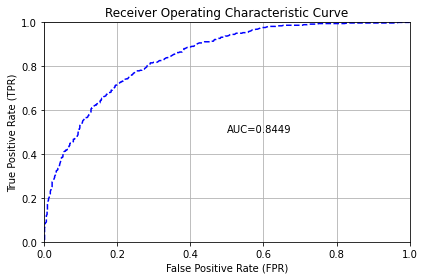

([0.0,
  0.0009852216748768472,
  0.0009852216748768472,
  0.0009852216748768472,
  0.0009852216748768472,
  0.0009852216748768472,
  0.0009852216748768472,
  0.0009852216748768472,
  0.0009852216748768472,
  0.0009852216748768472,
  0.0009852216748768472,
  0.0009852216748768472,
  0.0009852216748768472,
  0.0009852216748768472,
  0.0019704433497536944,
  0.0019704433497536944,
  0.0019704433497536944,
  0.0019704433497536944,
  0.002955665024630542,
  0.002955665024630542,
  0.0049261083743842365,
  0.005911330049261084,
  0.005911330049261084,
  0.005911330049261084,
  0.005911330049261084,
  0.005911330049261084,
  0.005911330049261084,
  0.005911330049261084,
  0.006896551724137931,
  0.007881773399014778,
  0.007881773399014778,
  0.007881773399014778,
  0.008866995073891626,
  0.008866995073891626,
  0.008866995073891626,
  0.008866995073891626,
  0.008866995073891626,
  0.008866995073891626,
  0.009852216748768473,
  0.01083743842364532,
  0.011822660098522168,
  0.011822660098

In [56]:
aml.leader.model_performance(test_data=test).plot()

In [57]:
aml.predict(test)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


predict,p0,p1
0,0.853938,0.146062
1,0.543103,0.456897
0,0.726419,0.273581
0,0.9761,0.0239004
1,0.194153,0.805847
0,0.959413,0.040587
1,0.594943,0.405057
1,0.617547,0.382453
1,0.428193,0.571807
0,0.958558,0.0414416


In [58]:
# aml.explain(test)

In [59]:
len(test)

1400

In [60]:
model =aml.leader

In [67]:
model_file = h2o.download_model(model)


In [62]:
# read_model_file=h2o.upload_model(model_file)


In [63]:
model.confusion_matrix

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_1_AutoML_1_20220528_191246

No model summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.11656521218865623
RMSE: 0.34141647908186307
LogLoss: 0.36422284092857676
Null degrees of freedom: 5631
Residual degrees of freedom: 5626
Null deviance: 6495.726044300329
Residual deviance: 4102.606080219489
AIC: 4114.606080219489
AUC: 0.8898220361451107
AUCPR: 0.7441152005908201
Gini: 0.7796440722902214

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34240748314605324: 


,,0,1,Error,Rate
0,0,3431.0,717.0,0.1729,(717.0/4148.0)
1,1,323.0,1161.0,0.2177,(323.0/1484.0)
2,Total,3754.0,1878.0,0.1847,(1040.0/5632.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.342407,0.690660,207.0
1,max f2,0.192496,0.789504,276.0
2,max f0point5,0.552545,0.694943,122.0
3,max accuracy,0.514334,0.831854,137.0
4,max precision,0.887262,1.000000,0.0
5,max recall,0.018570,1.000000,386.0
6,max specificity,0.887262,1.000000,0.0
7,max absolute_mcc,0.346809,0.569574,205.0
8,max min_per_class_accuracy,0.314531,0.805930,220.0
9,max mean_per_class_accuracy,0.255312,0.809970,248.0



Gains/Lift Table: Avg response rate: 26.35 %, avg score: 26.40 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010121,0.828813,3.728567,3.728567,0.982456,0.850264,0.982456,0.850264,0.037736,0.037736,272.856670,272.856670,0.037495
1,2,0.020064,0.805225,3.524066,3.627221,0.928571,0.817177,0.955752,0.833867,0.035040,0.072776,252.406623,262.722133,0.071571
2,3,0.030007,0.784332,3.388525,3.548127,0.892857,0.794033,0.934911,0.820668,0.033693,0.106469,238.852522,254.812676,0.103817
3,4,0.040128,0.770114,3.462241,3.526465,0.912281,0.778019,0.929204,0.809911,0.035040,0.141509,246.224051,252.646519,0.137652
4,5,0.050071,0.751967,3.117443,3.445241,0.821429,0.762678,0.907801,0.800532,0.030997,0.172507,211.744320,244.524096,0.166239
5,6,0.100142,0.667942,2.933838,3.189539,0.773050,0.709361,0.840426,0.754946,0.146900,0.319407,193.383801,218.953949,0.297710
6,7,0.150036,0.591752,2.552609,2.977732,0.672598,0.628658,0.784615,0.712950,0.127358,0.446765,155.260861,197.773170,0.402889
7,8,0.200107,0.524503,2.247481,2.795007,0.592199,0.559123,0.736469,0.674459,0.112534,0.559299,124.748141,179.500714,0.487698
8,9,0.300071,0.382360,1.691976,2.427547,0.445826,0.451140,0.639645,0.600063,0.169137,0.728437,69.197551,142.754749,0.581619
9,10,0.400036,0.266613,1.260555,2.135929,0.332149,0.320362,0.562805,0.530169,0.126011,0.854447,26.055546,113.592897,0.616984




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.13317899014880116
RMSE: 0.3649369673639561
LogLoss: 0.410884531081853
Null degrees of freedom: 5631
Residual degrees of freedom: 5627
Null deviance: 6496.632288464126
Residual deviance: 4628.203358105992
AIC: 4638.203358105992
AUC: 0.8491945262484827
AUCPR: 0.6581928965043137
Gini: 0.6983890524969654

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24836050821825834: 


,,0,1,Error,Rate
0,0,2999.0,1149.0,0.277,(1149.0/4148.0)
1,1,255.0,1229.0,0.1718,(255.0/1484.0)
2,Total,3254.0,2378.0,0.2493,(1404.0/5632.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.248361,0.636458,247.0
1,max f2,0.147527,0.755704,296.0
2,max f0point5,0.504686,0.636290,135.0
3,max accuracy,0.504686,0.807351,135.0
4,max precision,0.902382,1.000000,0.0
5,max recall,0.005366,1.000000,398.0
6,max specificity,0.902382,1.000000,0.0
7,max absolute_mcc,0.248361,0.491591,247.0
8,max min_per_class_accuracy,0.294492,0.762803,227.0
9,max mean_per_class_accuracy,0.248361,0.775583,247.0



Gains/Lift Table: Avg response rate: 26.35 %, avg score: 26.35 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010121,0.824636,3.195914,3.195914,0.842105,0.846642,0.842105,0.846642,0.032345,0.032345,219.591431,219.591431,0.030175
1,2,0.020064,0.801518,2.981902,3.089855,0.785714,0.811502,0.814159,0.829227,0.029650,0.061995,198.190219,208.985521,0.056932
2,3,0.030007,0.781311,3.185214,3.121453,0.839286,0.793096,0.822485,0.817255,0.031671,0.093666,218.521371,212.145329,0.086433
3,4,0.040128,0.764866,3.329077,3.173819,0.877193,0.772832,0.836283,0.806051,0.033693,0.127358,232.907741,217.381867,0.118439
4,5,0.050071,0.747376,2.914132,3.122250,0.767857,0.756568,0.822695,0.796224,0.028976,0.156334,191.413169,212.224962,0.144280
5,6,0.100142,0.664369,2.745426,2.933838,0.723404,0.705532,0.773050,0.750878,0.137466,0.293801,174.542639,193.383801,0.262942
6,7,0.150036,0.587822,2.228468,2.699271,0.587189,0.624467,0.711243,0.708841,0.111186,0.404987,122.846783,169.927112,0.346163
7,8,0.200107,0.516638,2.126360,2.555916,0.560284,0.552276,0.673469,0.669665,0.106469,0.511456,112.635966,155.591617,0.422738
8,9,0.300071,0.380657,1.590861,2.234422,0.419183,0.446879,0.588757,0.595447,0.159030,0.670485,59.086143,123.442160,0.502935
9,10,0.400036,0.270058,1.233592,1.984325,0.325044,0.321876,0.522858,0.527084,0.123315,0.793801,23.359170,98.432518,0.534639




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.768011,0.027011,0.747631,0.768166,0.811270,0.742958,0.770028
1,auc,0.849748,0.010028,0.838407,0.857901,0.860740,0.840562,0.851132
2,err,0.231989,0.027011,0.252369,0.231834,0.188730,0.257042,0.229972
3,err_count,261.600000,34.717430,293.000000,268.000000,211.000000,292.000000,244.000000
4,f0point5,0.580158,0.027238,0.564659,0.578139,0.624615,0.552831,0.580544
5,f1,0.644868,0.012644,0.635118,0.656410,0.658023,0.629442,0.645349
6,f2,0.727442,0.022705,0.725669,0.759193,0.695205,0.730701,0.726440
7,lift_top_group,3.086873,0.213196,3.042453,2.870861,2.983986,3.436744,3.100325
8,logloss,0.410750,0.015214,0.429935,0.401004,0.392280,0.421626,0.408907
9,max_per_class_error,0.266608,0.018259,0.272835,0.259953,0.277580,0.284514,0.238156



See the whole table with table.as_data_frame()


<bound method H2OBinomialModel.confusion_matrix of >

In [66]:
# recall = TP / TP + FN

(3431+1161)/(3431+1161+323+717)

0.8153409090909091

In [68]:
model.auc()

0.8898220361451107

In [3]:
pip install pipreqs

  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13704 sha256=d99ba573ec95d444b591481539d9d2c14d2a5f31e752f8965279c01fac30d93b
  Stored in directory: /Users/icluster/Library/Caches/pip/wheels/56/ea/58/ead137b087d9e326852a851351d1debf4ada529b6ac0ec4e8c
Successfully built docopt
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip freeze -r requirements.txt | sed '/freeze/,$ d'

ERROR: Exception:
Traceback (most recent call last):
  File "/Users/icluster/opt/anaconda3/lib/python3.8/site-packages/pip/_internal/cli/base_command.py", line 228, in _main
    status = self.run(options, args)
  File "/Users/icluster/opt/anaconda3/lib/python3.8/site-packages/pip/_internal/commands/freeze.py", line 101, in run
    for line in freeze(**freeze_kwargs):
  File "/Users/icluster/opt/anaconda3/lib/python3.8/site-packages/pip/_internal/operations/freeze.py", line 92, in freeze
    with open(req_file_path) as req_file:
FileNotFoundError: [Errno 2] No such file or directory: 'requirements.txt'
Note: you may need to restart the kernel to use updated packages.
